In [1]:
%matplotlib notebook

# Frozen Lake

Frozen Lake is one of the environments in gym, ideal to play around with value and policy iteration:

https://gym.openai.com/envs/FrozenLake8x8-v0/


The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

The surface is described using a grid like the following:

<table>
    <tr><td>SFFF</td><td>(S: starting point, safe)</td></tr>
    <tr><td>FHFH</td><td>(F: frozen surface, safe)</td></tr>
    <tr><td>FFFH</td><td>(H: hole, fall to your doom)</td></tr>
    <tr><td>HFFG</td><td>(G: goal, where the frisbee is located)</td></tr>
</table>

The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.


The following code is based on [Justin Francis](https://github.com/wagonhelm/Value-Iteration)' solution.

You might need to install gym

`pip3 install -U gym`

or 

`conda install -c conda-forge gym`

In [2]:
#!conda install gym
#!pip install gym

In [3]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output

In [4]:
env = gym.make('FrozenLake8x8-v0')

In [5]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("States =",n_states,"; Actions =",n_actions)

States = 64 ; Actions = 4


In [6]:
env.render()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


Implemented By Using Pseudo Code From: <br />
[Reinforcement Learning: An Introduction](http://www.incompleteideas.net/sutton/book/the-book-2nd.html) <br />
By: Richard Sutton and Andrew Barto

In [7]:
values = np.zeros(n_states)
gamma = 0.999 ## Degradation factor

## Value iteration

In [8]:
env.env.P[0][0]

[(0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 8, 0.0, False)]

<IPython.core.display.Javascript object>


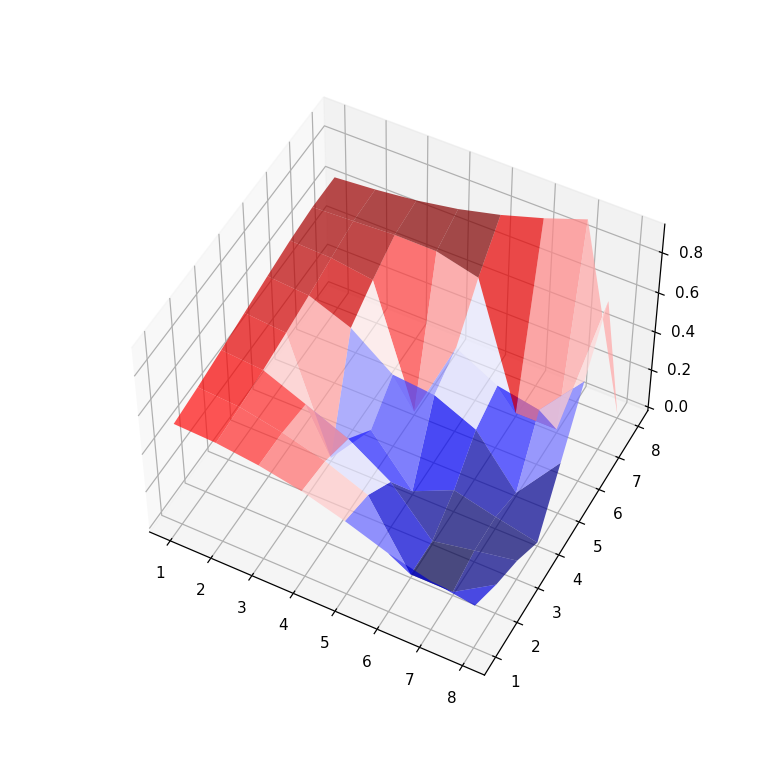

In [9]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1,projection='3d')
x = np.outer(np.linspace(1,8,8), np.ones(8))
y = x.copy().T
surf=None

while True:
    delta = 0
    for state in reversed(range(n_states)):
        v = values[state]
        values[state] = np.max([sum([p*(r + gamma*values[s_]) for p, s_, r, _ in env.env.P[state][a]]) for a in range(env.env.nA)])
        delta = max(delta,abs(v-values[state]))

    # Show the found values
    if surf:
        surf.remove()
    z = values.reshape(8,8)
    surf=ax.plot_surface(x, y, z, cmap='seismic', rstride=1, cstride=1, linewidth=0, alpha=0.7)
    fig.canvas.draw()
    
    # Stop if too small the change
    if delta < 1.1e-2:
        break
    

In [10]:
history = []
bestAverage = []
state = env.reset()
test_episodes = 1000

for i in range(1,test_episodes):
    while True:
        action = np.argmax([sum([p*(r + gamma*values[s_]) for p, s_, r, _ in env.env.P[state][a]]) for a in range(env.env.nA)])
        state, reward, done, info = env.step(action)

        if done:
            clear_output(wait=True)
            env.render()

            history.append(reward)
            env.reset()           
            
            break
        
    if len(history)>=100 and np.mean(history[i-100:i]) >= 0.30:
        bestAverage.append(np.mean(history[i-100:i]))
        
print('Best Average Score in {} Episodes: {:4.3f}'.format(test_episodes, np.max(bestAverage)))

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Best Average Score in 1000 Episodes: 0.910


## TODO

In [11]:
## Copy the code above and modify it to show the agent's movements


# Learning the MDP

Value Iteration assumes that the entire MDP (i.e. transition probabilities) is known but in most cases the MDP is unknown.  Let's try and solve FrozenLake-v0 by trying to estimate all p(s',r|s,a).

In [12]:
env = gym.make('FrozenLake-v0')

In [13]:
n_states = env.observation_space.n
n_actions = env.action_space.n

In [14]:
env.render()


SFFF
FHFH
FFFH
HFFG


We can also think of our states like the following:

In [15]:
states = np.zeros([n_states])
for i in range(n_states):
    states[i] = i
states.reshape(4,4)

array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.],
       [12., 13., 14., 15.]])

There are 4 possible actions with their associated labels

[0] = Left <br />
[1] = Down <br />
[2] = Right <br />
[3] = Up

In [16]:
table = np.zeros([n_states,n_states,n_actions,4])

Table represents the number of initial states (**s**), future states (**s'**), number of possible actions(**a**), and the last 4 indexes represent:

[0] - Reward<br />
[1] - How many times action is taken given state (**#a|s**)<br />
[2] - How many times state transitioned to **s'** given **a** (**#s'|a**)<br />
[3] - Probability of transitioning to **s'** from **s** given action **a** (**p(s'|s,a)**)<br />

Since the rewards for state transitions do not change we do not need to calculate **p(s',r|s,a**)



Let's make a function that can evaluate all possible state transitions for any given state.

In [17]:
def possibleStates(s):
    p_states = []
    for i in range(n_states):
        if np.max(table[s,i,:,[3]]):
            p_states.append(i)
    return p_states

def actionProbs(s):
    for i in possibleStates(s):
        print('-----------------------------------------------------')
        for a in range(n_actions):
            print('P: State: [{}] -> State: [{}] via Action: [{}] is {:4.4f}'.format(s,i,a,table[s,i,a,3]))


Let's evaluate the probability of each state transition from state[0] by sampling all possible actions from the initial state 100,000 times.  By [law of large numbers](https://www.youtube.com/watch?v=Ws63I3F7Moc) we will converge to the state transition probabilities.  

In [18]:
for action in range(n_actions):
    for _ in range(10000):
        state = env.reset()        
        state2, reward, done, info = env.step(action)

        table[state,state2,action,0] = reward
        table[state,:,action,1] += 1
        table[state,state2,action,2] += 1
        table[state,:,action,3] = table[state,:,action,2] / table[state,:,action,1]

And now we can display the probability of transitioning to any possible future state given any action.

In [19]:
actionProbs(env.reset())

-----------------------------------------------------
P: State: [0] -> State: [0] via Action: [0] is 0.6620
P: State: [0] -> State: [0] via Action: [1] is 0.3430
P: State: [0] -> State: [0] via Action: [2] is 0.3368
P: State: [0] -> State: [0] via Action: [3] is 0.6641
-----------------------------------------------------
P: State: [0] -> State: [1] via Action: [0] is 0.0000
P: State: [0] -> State: [1] via Action: [1] is 0.3309
P: State: [0] -> State: [1] via Action: [2] is 0.3252
P: State: [0] -> State: [1] via Action: [3] is 0.3359
-----------------------------------------------------
P: State: [0] -> State: [4] via Action: [0] is 0.3380
P: State: [0] -> State: [4] via Action: [1] is 0.3261
P: State: [0] -> State: [4] via Action: [2] is 0.3380
P: State: [0] -> State: [4] via Action: [3] is 0.0000


So if we wanted to transition to state 4, the best possible action is [0] (LEFT) because from state 0 we will have a 66% chance of staying in state 0 and a 33% chance of transitioning to state 4.  

One way to solve this environment we will have to sample it a large amount of times and keep track of the estimated value of each state.  We will create a value table of 16 for each possible states.  

We update our state value using the TD Target also known as Tabular TD(0) for iteratively estimating $V^\ast$. This is a Temporal-Difference (TD) approach which tries to estimate the optimal value as a filter:
$$
  V(s_t) \leftarrow (1-\alpha)V(s_t) + \alpha(R_{t+1} + \gamma V(s_{t+1}))
$$
Rearranging the terms, we get
$$
  V(s_t) \leftarrow V(s_t) + \alpha(R_{t+1} + \gamma V(s_{t+1}) - V(s_t))
$$

We will use learning rate $\alpha$ to determine the rate of update we apply to $V(s_t)$.  The value can be considered our expected return in a given state.

We will explore the environment by behaving completely randomly updating the values at the same time which will be used later for another policy for completing the environment.  This is also known as off-policy learning since we are not adapting the policy we are using to explore the environment.  Since it's exploring randomly it sometimes does not converge nicely without a very large amount of episodes. 

In [20]:
value = np.zeros([n_states])
table = np.zeros([n_states,n_states,n_actions,4])

In [21]:
gamma = 0.999
alpha = 0.1
history = []
state = env.reset()
n_episodes = 500000
n_steps = 500
n_solved = 0
for i in range(n_episodes):
    state = env.reset()
    for _ in range(n_steps):
        action = env.action_space.sample()
        state2, reward, done, info = env.step(action)

        table[state,state2,action,0] = reward
        table[state,:,action,1] += 1
        table[state,state2,action,2] += 1
        table[state,:,action,3] = table[state,:,action,2] / table[state,:,action,1]
        
        value[state] += alpha*(reward + gamma*value[state2] - value[state])
        
        state = state2
        if done:
            if reward == 1:
                n_solved += 1
            break
              
print('Solved {} Times In {} Episodes with average reward of {}'.format(n_solved, i+1, n_solved/n_episodes))

Solved 6915 Times In 500000 Episodes with average reward of 0.01383


In [22]:
value2 = value.reshape(4,4)
for i in range(4):
    print(value2[i,:])

[0.00771398 0.00788829 0.01411565 0.00602077]
[0.00831815 0.         0.02001852 0.        ]
[0.01732416 0.04033497 0.11929661 0.        ]
[0.         0.07983871 0.22654145 0.        ]


So the holes and and goal point do not have any values because they do not lead to any future states.  When trying to estimate the best action to take we will take the probabilities of of all actions that lead to the best state and subtract them by the action probabilities for the worst state.  This ensures that actions that have a probability of leading to a worse state are not considered.  Since the holes and finish point do not have values, we will assign their values to be the expected reward for transitioning to that state.

In [23]:
def bestState(s):
    beststate = s
    for i in possibleStates(s):
        if value[i] + np.max(table[:,i,:,0]) > value[beststate]:
            beststate = i
    return beststate

def worstState(s):
    worststate = s
    for i in possibleStates(s):
        if value[i] + np.max(table[:,i,:,0]) < value[worststate]:
            worststate = i
    return worststate

def bestAction(s):
    a = np.argmax((table[s,bestState(s),:,[3]])-(table[s,worstState(s),:,[3]]))
    return a

In [24]:
history = []
for i in range(1,1000):
    while True:
        action = bestAction(state)
        state, reward, done, info = env.step(action)

        if done:
            history.append(reward)
            env.reset()
            break

    # Open AI's Standards For Solving
    if len(history)>=100 and np.mean(history[i-100:i]) >= 0.78:
        print('Solved in {} attempts'.format(i))
        break


There we have it by only behaving completely random and updating our expected state values we are able to solve the environment.  Here is the graph of the estimated state values. [1,1] represents the start state and [4,4] the finish state.

<IPython.core.display.Javascript object>


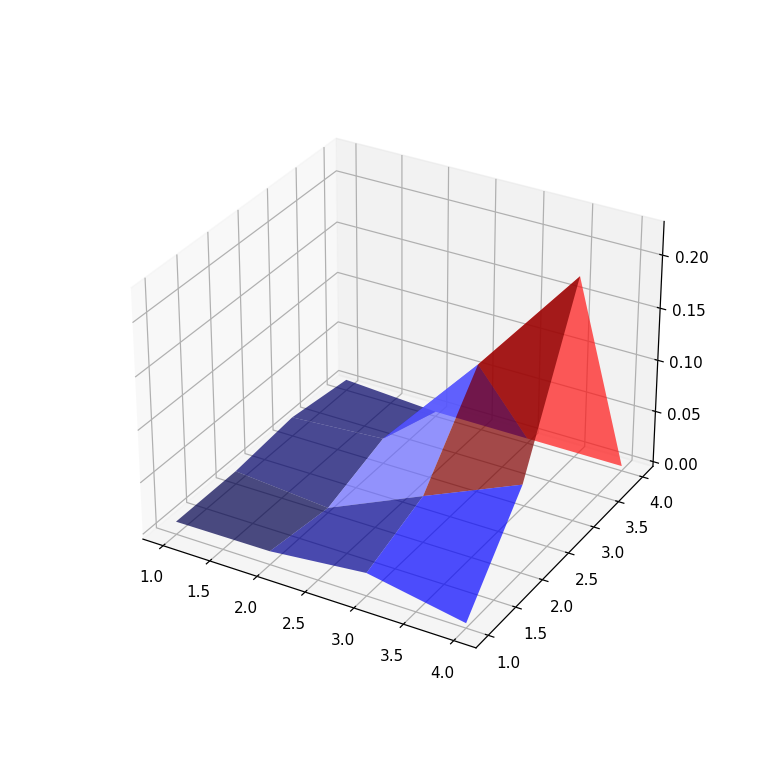

In [25]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
x = np.outer(np.linspace(1, 4, 4), np.ones(4))
y = x.copy().T
z = value2
ax.plot_surface(x, y, z, cmap='seismic', rstride=1, cstride=1, linewidth=0, alpha=0.7)

# Tareas:


1. Transformar lo anterior para el caso 8x8
2. Visualizar una corrida